# Nesting MicroHH in ERA5

This notebook contains documentation and examples for nesting MicroHH with open boundary conditions in ERA5.

Nesting LES-in-LES is documented separately in `TODO.ipynb`.

In [1]:
# Standard library

# Third-party.
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import ls2d
import cartopy.crs as ccrs

# Local library
from microhhpy.spatial import Domain, plot_domains, Vertical_grid_2nd
from microhhpy.openbc import create_initial_fields_from_era5

TF = np.float32

## Spatial projection

To nest LES in ERA5, a transformation is needed from the LES grid (in meters) to geographic coordinates (latitude / longitude in degrees).

The `Domain()` class provides a simple way to define the domain. The spatial transformation is performed using `pyproj`, based on the `proj_str` definition.

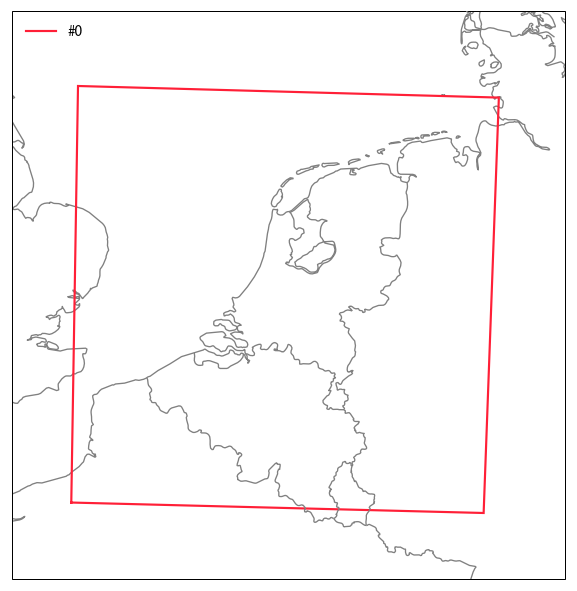

In [2]:
dom0 = Domain(
    xsize=512_000,
    ysize=512_000,
    itot=256,
    jtot=256,
    n_ghost=3,
    lon=4.92,
    lat=51.97,
    anchor='center',
    proj_str='+proj=utm +zone=31 +ellps=intl +towgs84=-87,-98,-121,0,0,0,0 +units=m +no_defs +type=crs'
    )

plot_domains([dom0], use_projection=True)

Note that each `Domain` instance includes two projections: one with ghost cells and one without. The version with ghost cells is needed for generating the lateral boundary conditions.

The padded projection actually includes `nghost + 1` ghost cells. The extra cells are needed to create divergence free fields in the east- and north-most ghost cells.

In [3]:
print(dom0.proj.itot, dom0.proj_pad.itot)

256 264


Coordinate pairs are available for each grid point location `(u, v, scalar)`:

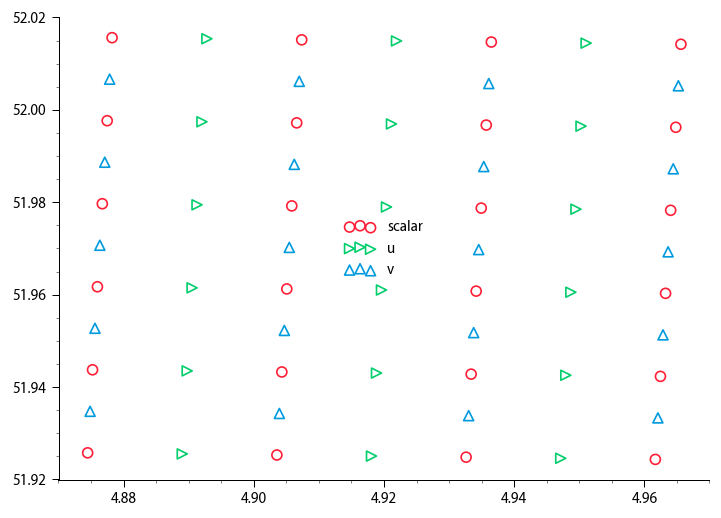

In [4]:
plt.figure()

plt.scatter(dom0.proj.lon,   dom0.proj.lat,   marker='o', facecolor='none', edgecolor='C0', label='scalar')
plt.scatter(dom0.proj.lon_u, dom0.proj.lat_u, marker='>', facecolor='none', edgecolor='C1', label='u')
plt.scatter(dom0.proj.lon_v, dom0.proj.lat_v, marker='^', facecolor='none', edgecolor='C2', label='v')

plt.xlim(dom0.proj.central_lon-0.05, dom0.proj.central_lon+0.05)
plt.ylim(dom0.proj.central_lat-0.05, dom0.proj.central_lat+0.05)

plt.legend()

## Vertical grid

To ensure that the initial LES fields are divergence-free, we need the _exact_ vertical grid definition from MicroHH, along with the base-state density at both full and half levels. For simplicity, we use a dummy density here.

In [5]:
zsize = 3200
ktot = 128
dz = zsize / ktot
z = np.arange(dz/2, zsize, dz)

vgrid = Vertical_grid_2nd(z, zsize, remove_ghost=True)

rho  = 1.2 - vgrid.z /10000
rhoh = 1.2 - vgrid.zh/10000

## ERA5 data

For now, we use (LS)²D to download and read the ERA5 data. This can be simplified later, as we only need a few 3D fields from ERA5, and do not use the large-scale forcings typically required for a doubly periodic LES.

In [6]:
settings = {
    'start_date'  : datetime(year=2022, month=4, day=1, hour=12),
    'end_date'    : datetime(year=2022, month=4, day=2, hour=16),
    'central_lon' : dom0.proj.central_lon,
    'central_lat' : dom0.proj.central_lat,
    'area_size'   : 5,
    'case_name'   : 'slocs_rf',
    'era5_path'   : '/home/scratch1/bart/LS2D_ERA5/',
    'era5_expver' : 1,
    'cdsapirc'    : '/home/bart/.cdsapirc_ads'
    }

era5 = ls2d.Read_era5(settings)

Reading ERA5 from 2022-04-01 12:00:00 to 2022-04-02 16:00:00 [11-06: 07:47]


## Initial conditions

The initial conditions are (not so...) simply the 3D ERA5 fields tri-linearly interpolated to the LES grid.

To reduce the blocky structures that result from interpolating coarse ERA5 data, a Gaussian filter with standard deviation `sigma_h` is applied after interpolation.

### Momentum & divergence
The momentum fields require special treatment because they must be divergence-free. To achieve this, the `(u, v)` velocity components are corrected such that:

1. The resulting fields are divergence-free, and:
2. The domain-mean vertical velocity in LES matches that from ERA5.

Note that we correct the horizontal velocities as `u,v >> w`, and correcting `w` can cause a significant mismatch in subsidence between LES and ERA5.

### Output

The initial conditions are written directly as binary input files (e.g. `u.0000000`) for MicroHH in the specified `output_dir`. By setting a `name_suffix`, the files can optionally be written with a custom name, such as `u_some_name.0000000`. This allows you to overwrite the homogeneous 3D restart files generated during the `init` phase of MicroHH with the fields derived from ERA5.

In [11]:
fields_era = {
    'u': era5.u[0,:,:,:],
    'v': era5.v[0,:,:,:],
    'w': era5.w[0,:,:,:],
    'thl': era5.thl[0,:,:,:],
    'qt': era5.qt[0,:,:,:],
}

z_era = era5.z[0,:,:,:]

sigma_h = 60_000
correct_div_h = True

create_initial_fields_from_era5(
    fields_era,
    era5.lons,
    era5.lats,
    z_era,
    vgrid.z,
    vgrid.zh,
    rho,
    rhoh,
    dom0,
    correct_div_h,
    sigma_h,
    output_dir='.',
    name_suffix='era',
    dtype=TF)

[2025/06/11 07:48:06] [microhhpy] [DEBUG] Using Gaussian filter with sigma = 5 grid cells'
[2025/06/11 07:48:06] [microhhpy] [DEBUG] Interpolating initial field thl from ERA to LES'
[2025/06/11 07:48:06] [microhhpy] [DEBUG] Interpolating initial field qt from ERA to LES'


/home/bart/meteo/models/microhhpy/.venv/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1768: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


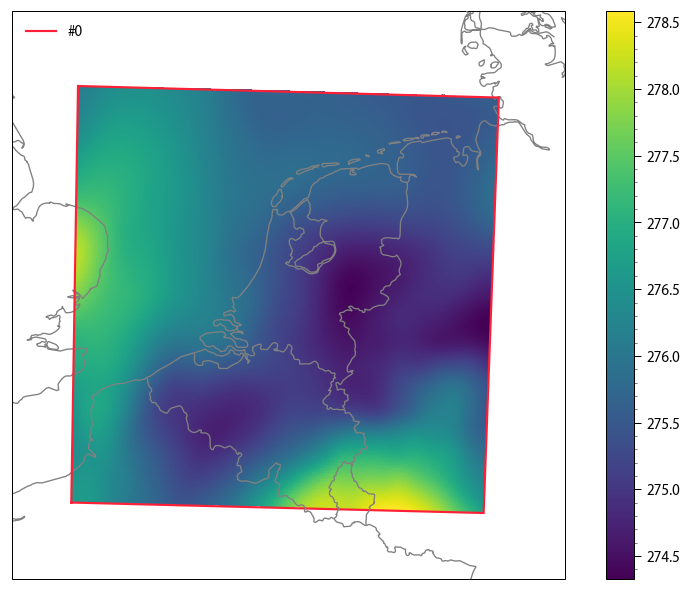

In [12]:
thl = np.fromfile('thl_era.0000000', dtype=TF).reshape((vgrid.kmax, dom0.jtot, dom0.itot))

plot_domains([dom0], use_projection=True)
plt.pcolormesh(dom0.proj.lon, dom0.proj.lat, thl[0,:,:], transform=ccrs.PlateCarree())
plt.colorbar()